In [ ]:
import pandas as pd
from scipy import stats
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scorecardpy as sc

In [3]:
# Set theme to "whitegrid"
sns.set_style("whitegrid")

# Make custom color palette from list of colors
PLOT_COLORS = [
    "#F72585",
    "#B5179E",
    "#7209B7",
    "#560BAD",
    "#480CA8",
    "#3A0CA3",
    "#3F37C9",
    "#4361EE",
    "#4895EF",
    "#4CC9F0",
]

custom_palette = sns.color_palette(PLOT_COLORS)

# Silence seaborn FutureWarning and UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


def get_color(i: int) -> str:
    return PLOT_COLORS[i % len(PLOT_COLORS)]

In [4]:
df: pd.DataFrame = pd.read_excel("../data/kredyty_auto_Scoring2025s.xlsx")

df.head()

,LP,data_akceptacji,grupa_ryzyka,kod_partnera,typ_umowy,scoring_FICO,okres_kredytu,kwota_kredytu,oproc_refin,oproc_konkur,koszt_pieniadza,oproc_propon,akceptacja_klienta
0,1,2005-04-17,2,2,R,702,48,26500.00,0.0399,0.0499,0.011,0.0659,0
1,2,2005-04-17,2,2,N,719,72,34999.99,0.0000,0.0479,0.011,0.0599,0
2,3,2005-04-17,1,3,N,802,60,28000.00,0.0000,0.0399,0.011,0.0355,0
3,4,2005-04-17,1,1,R,723,60,20750.69,0.0675,0.0499,0.011,0.0489,1
4,5,2005-04-17,3,1,U,690,72,19999.99,0.0000,0.0529,0.011,0.0679,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   LP                  40000 non-null  int64         
 1   data_akceptacji     40000 non-null  datetime64[ns]
 2   grupa_ryzyka        40000 non-null  int64         
 3   kod_partnera        40000 non-null  int64         
 4   typ_umowy           40000 non-null  object        
 5   scoring_FICO        40000 non-null  int64         
 6   okres_kredytu       40000 non-null  int64         
 7   kwota_kredytu       40000 non-null  float64       
 8   oproc_refin         40000 non-null  float64       
 9   oproc_konkur        40000 non-null  float64       
 10  koszt_pieniadza     40000 non-null  float64       
 11  oproc_propon        40000 non-null  float64       
 12  akceptacja_klienta  40000 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(6), ob

In [39]:
TARGET = "akceptacja_klienta"

EXCLUDED_FEATURES = ["LP", "data_akceptacji"]

Zmienne pochodne

In [40]:
df["delta_oproc_konkurencji"] = df["oproc_propon"] - df["oproc_konkur"]
df["delta_oproc_refinansowana"] = df["oproc_propon"] - df["oproc_refin"]

In [41]:
df["is_n"] = df.apply(lambda row: 1 if row["typ_umowy"] == "N" else 0, axis=1)
df["is_r"] = df.apply(lambda row: 1 if row["typ_umowy"] == "R" else 0, axis=1)

Statystyki opisowe

In [42]:
filtered_columns = df.select_dtypes(include=["number"]).columns.difference(
    EXCLUDED_FEATURES
)

non_binary_columns = [col for col in filtered_columns if df[col].nunique() > 2]

df[non_binary_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
delta_oproc_konkurencji,40000.0,0.016236,0.019731,-0.016400,0.000000,0.012000,0.031500,0.077600
delta_oproc_refinansowana,40000.0,0.042223,0.045108,-0.195400,0.014400,0.048900,0.071900,0.112500
grupa_ryzyka,40000.0,2.053725,1.090307,1.000000,1.000000,2.000000,3.000000,4.000000
kod_partnera,40000.0,2.103425,0.912825,1.000000,1.000000,2.000000,3.000000,3.000000
koszt_pieniadza,40000.0,0.014169,0.002618,0.010900,0.011138,0.013800,0.016300,0.021010
kwota_kredytu,40000.0,24211.651536,11211.386637,4526.620000,15703.592500,23000.000000,30906.825000,100000.000000
okres_kredytu,40000.0,57.186900,11.386207,36.000000,48.000000,60.000000,60.000000,72.000000
oproc_konkur,40000.0,0.049631,0.005794,0.029900,0.044900,0.049900,0.053900,0.062900
oproc_propon,40000.0,0.065867,0.020704,0.025900,0.048200,0.063400,0.082400,0.113500
oproc_refin,40000.0,0.023644,0.041133,0.000000,0.000000,0.000000,0.055000,0.240000


In [43]:
md = df[non_binary_columns].describe().T

print(md.to_markdown(floatfmt=".3f"))

|                           |     count |      mean |       std |      min |       25% |       50% |       75% |        max |
|:--------------------------|----------:|----------:|----------:|---------:|----------:|----------:|----------:|-----------:|
| delta_oproc_konkurencji   | 40000.000 |     0.016 |     0.020 |   -0.016 |     0.000 |     0.012 |     0.031 |      0.078 |
| delta_oproc_refinansowana | 40000.000 |     0.042 |     0.045 |   -0.195 |     0.014 |     0.049 |     0.072 |      0.113 |
| grupa_ryzyka              | 40000.000 |     2.054 |     1.090 |    1.000 |     1.000 |     2.000 |     3.000 |      4.000 |
| kod_partnera              | 40000.000 |     2.103 |     0.913 |    1.000 |     1.000 |     2.000 |     3.000 |      3.000 |
| koszt_pieniadza           | 40000.000 |     0.014 |     0.003 |    0.011 |     0.011 |     0.014 |     0.016 |      0.021 |
| kwota_kredytu             | 40000.000 | 24211.652 | 11211.387 | 4526.620 | 15703.592 | 23000.000 | 30906.825 | 10000

Rozkłady zmiennych

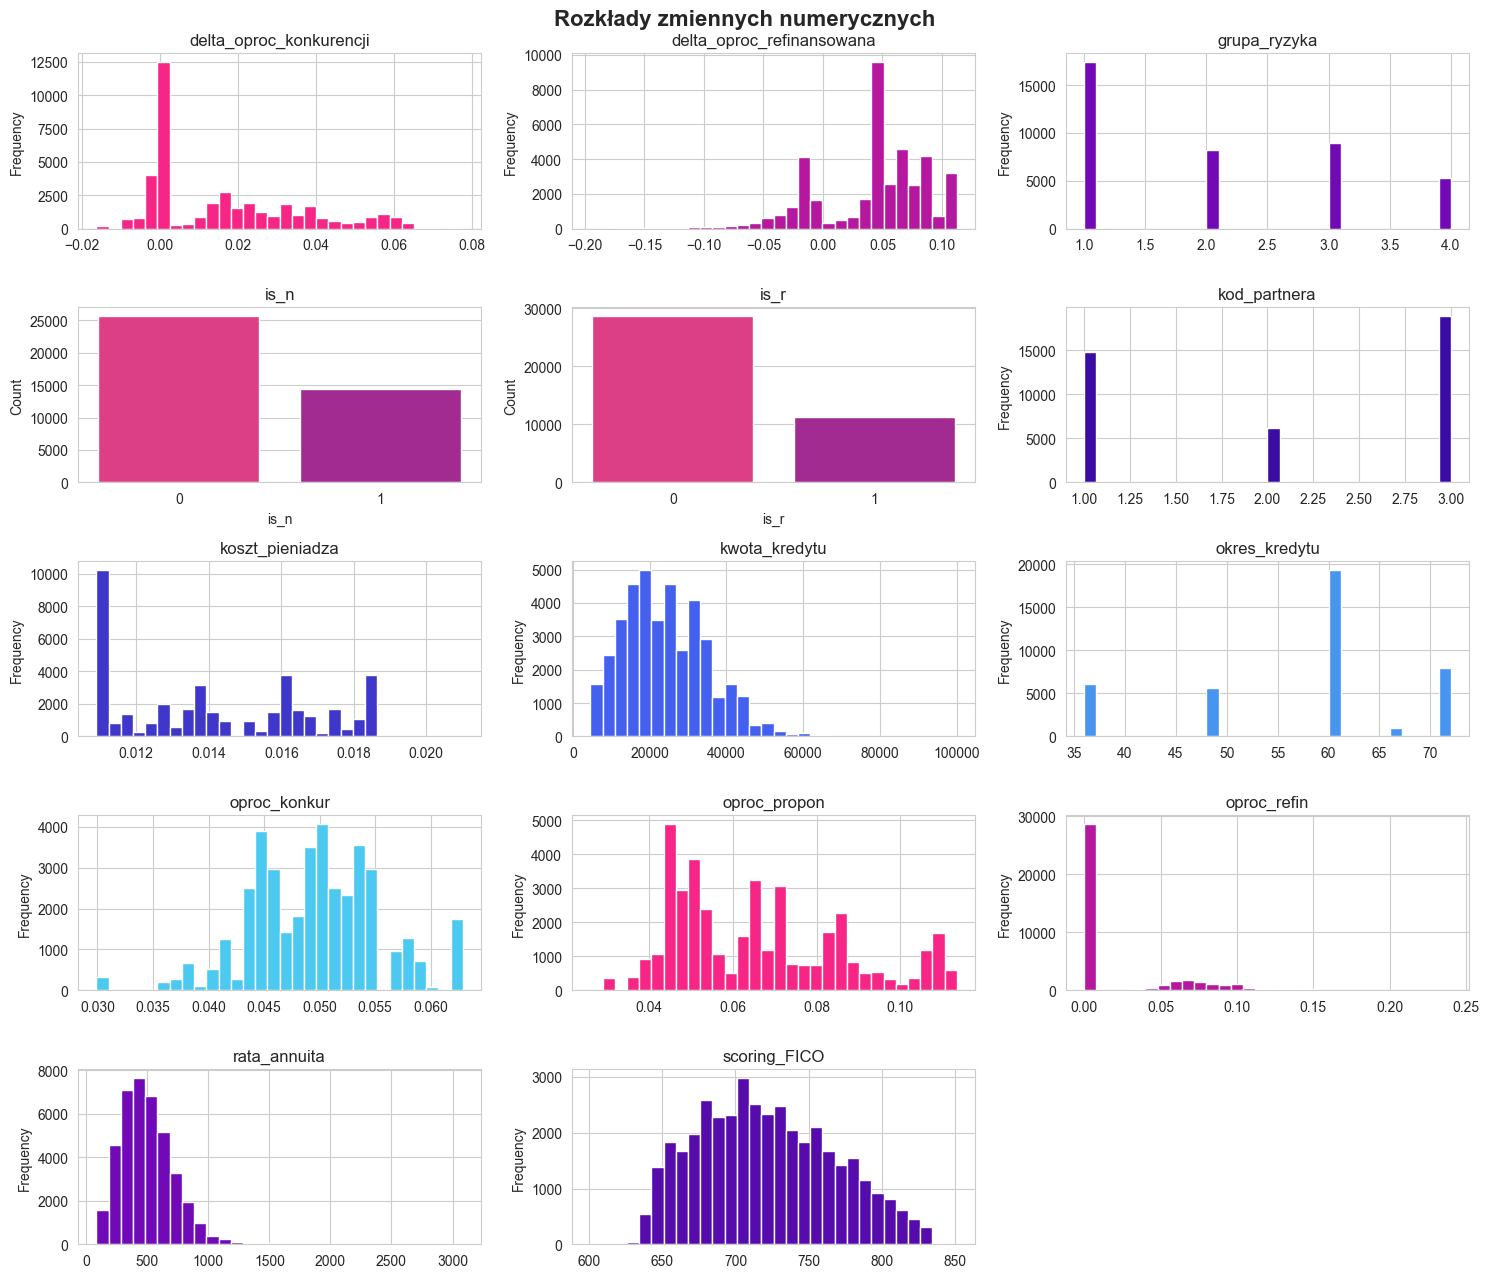

In [44]:
# Select numeric columns excluding those in EXCLUDED_FEATURES
numeric_columns = df.select_dtypes(include=["number"]).columns.difference(
    EXCLUDED_FEATURES + [TARGET]
)

# Set up the subplot grid
num_cols = 3
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 13))
axes = axes.flatten()

fig.subplots_adjust(hspace=0.5)

fig.suptitle("Rozkłady zmiennych numerycznych", fontsize=16, fontweight="bold")

# Plot histograms or bar plots
for i, col in enumerate(numeric_columns):
    ax = axes[i]
    if df[col].nunique() == 2:  # Use bar plot for binary variables
        value_counts = df[col].value_counts()
        sns.barplot(
            x=value_counts.index, y=value_counts.values, ax=ax, palette=custom_palette
        )
        ax.set_ylabel("Count")
    else:  # Use histogram for non-binary variables
        bins = 30
        df[col].hist(bins=bins, ax=ax, color=get_color(i))
        ax.set_ylabel("Frequency")
    ax.set_title(f"{col}")

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

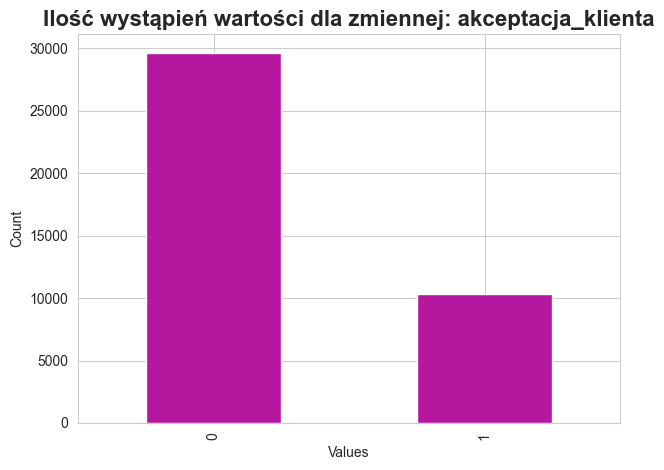

In [45]:
# Plot value counts for the target variable
target_value_counts = df[TARGET].value_counts()
target_value_counts.plot(kind="bar", color=get_color(1))

plt.title(
    f"Ilość wystąpień wartości dla zmiennej: {TARGET}", fontsize=16, fontweight="bold"
)
plt.ylabel("Count")
plt.xlabel("Values")
plt.tight_layout()
plt.show()

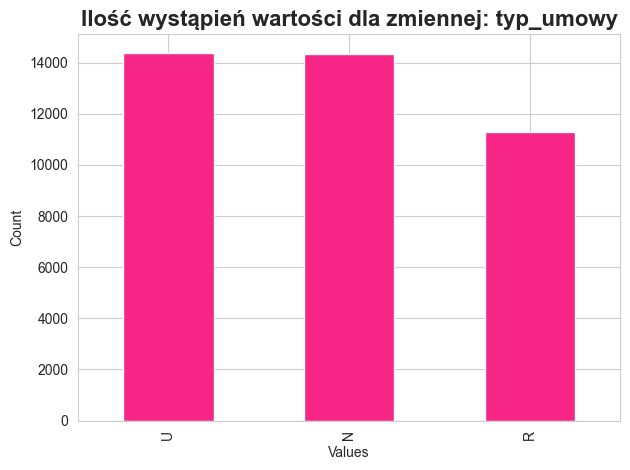

In [46]:
# Select the descriptive (non-numeric) variable
descriptive_column = "typ_umowy"

# Plot value counts for the descriptive variable
value_counts = df[descriptive_column].value_counts()
value_counts.plot(kind="bar", color=get_color(0))

plt.title(
    f"Ilość wystąpień wartości dla zmiennej: {descriptive_column}",
    fontsize=16,
    fontweight="bold",
)
plt.ylabel("Count")
plt.xlabel("Values")
plt.tight_layout()
plt.show()


Siły predykcyjne

In [47]:
def calculate_annuit_rate(row):
    percentage = row["oproc_propon"]
    n = row["okres_kredytu"]

    if (
        pd.isnull(row["kwota_kredytu"])
        or pd.isnull(percentage)
        or pd.isnull(n)
        or n == 0
    ):
        return None  # obsługa braków danych lub dzielenia przez zero

    r = percentage / 12  # miesięczna stopa procentowa jako ułamek

    rata = row["kwota_kredytu"] * (r * (1 + r) ** n) / ((1 + r) ** n - 1)
    return rata


df["rata_annuita"] = df.apply(calculate_annuit_rate, axis=1)

In [48]:
def compute_woe_iv(
    df: pd.DataFrame, feature: str, target: str, bins: int = 10
) -> float:
    """Compute Information Value for a single feature."""
    series = df[feature]

    if pd.api.types.is_numeric_dtype(series):
        binned = pd.qcut(series, bins, duplicates="drop")
    else:
        binned = series.astype("object")

    tmp = pd.DataFrame({feature: binned, target: df[target]})
    grp = tmp.groupby(feature, observed=False)[target].agg(["count", "sum"])
    grp["non_event"] = grp["count"] - grp["sum"]

    grp["dist_event"] = grp["sum"] / grp["sum"].sum()
    grp["dist_non_event"] = grp["non_event"] / grp["non_event"].sum()

    grp = grp[(grp["dist_event"] > 0) & (grp["dist_non_event"] > 0)]
    grp["woe"] = np.log(grp["dist_event"] / grp["dist_non_event"])
    iv = ((grp["dist_event"] - grp["dist_non_event"]) * grp["woe"]).sum()
    return float(iv)


def cramers_v(x: pd.Series, y: pd.Series) -> float:
    """Compute Cramer's V statistic for association between two categorical series."""
    contingency = pd.crosstab(x, y)
    chi2, _, _, _ = stats.chi2_contingency(contingency)
    n = contingency.values.sum()
    phi2 = chi2 / n
    r, k = contingency.shape
    return float(np.sqrt(phi2 / min(k - 1, r - 1)))

In [49]:
# run over all predictors
features = [c for c in df.columns if c not in EXCLUDED_FEATURES + [TARGET]]
iv_list = []
cv_list = []
for f in features:
    try:
        iv_list.append({"feature": f, "IV": compute_woe_iv(df, f, TARGET)})
        cv_list.append({"feature": f, "CramersV": cramers_v(df[f], df[TARGET])})
    except Exception as e:
        print(f"skipping {f}: {e}")

iv_df = pd.DataFrame(iv_list).sort_values("IV", ascending=False).reset_index(drop=True)
cv_df = (
    pd.DataFrame(cv_list)
    .sort_values("CramersV", ascending=False)
    .reset_index(drop=True)
)

In [50]:
iv_df

,feature,IV
0,rata_annuita,1.005477
1,kwota_kredytu,0.942273
2,delta_oproc_refinansowana,0.533540
3,typ_umowy,0.403734
4,oproc_refin,0.283355
5,delta_oproc_konkurencji,0.231183
6,oproc_konkur,0.213204
7,oproc_propon,0.210357
8,grupa_ryzyka,0.107380
9,scoring_FICO,0.084846


In [51]:
cv_df

,feature,CramersV
0,rata_annuita,0.960104
1,kwota_kredytu,0.858116
2,delta_oproc_refinansowana,0.444690
3,delta_oproc_konkurencji,0.322121
4,oproc_propon,0.313878
5,oproc_refin,0.298565
6,typ_umowy,0.265231
7,oproc_konkur,0.243613
8,is_n,0.239631
9,is_r,0.212574


In [52]:
X = df[features].apply(lambda col: pd.factorize(col, sort=True)[0])
y = df[TARGET].astype(int)

mi = mutual_info_classif(X, y, discrete_features="auto", random_state=42)
mi_df = pd.DataFrame({"feature": features, "MI": mi}).sort_values("MI", ascending=False)

mi_df

,feature,MI
5,kwota_kredytu,0.158065
14,rata_annuita,0.131825
11,delta_oproc_refinansowana,0.075133
9,oproc_propon,0.048835
10,delta_oproc_konkurencji,0.044213
2,typ_umowy,0.038418
12,is_n,0.035952
7,oproc_konkur,0.032108
6,oproc_refin,0.031750
1,kod_partnera,0.022023


Odpalanko części drugiej testy bombowe

In [53]:
df_filtered = df[features + [TARGET]].copy()

In [57]:
train, test = sc.split_df(df_filtered, TARGET, ratio=0.8, seed=42).values()

len(train), len(test)

(32000, 8000)

In [58]:
bins = sc.woebin(
    df_filtered,
    y=TARGET,
)

[INFO] creating woe binning ...


/Users/kacperkedzierski/Documents/Code/Repositories/scoring-project/.venv/lib/python3.12/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/kacperkedzierski/Documents/Code/Repositories/scoring-project/.venv/lib/python3.12/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  init_bin = dtm.groupby('bin', group_keys=False)['y'].agg([n0, n1])\
/Users/kacperkedzierski/Documents/Code/Repositories/scoring-project/.venv/lib/python3.12/site-packages/scorecardpy/woebin.py:320

In [60]:
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [62]:
y_train = train_woe[TARGET]
X_train = train_woe.drop(columns=[TARGET])

y_test = test_woe[TARGET]
X_test = test_woe.drop(columns=[TARGET])

In [63]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    penalty="l2",
    C=0.01,
    solver="liblinear",
    max_iter=1000,
    random_state=42,
)
lr.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=1000, random_state=42, solver='liblinear')

In [64]:
train_pred = lr.predict_proba(X_train)[:, 1]
test_pred = lr.predict_proba(X_test)[:, 1]

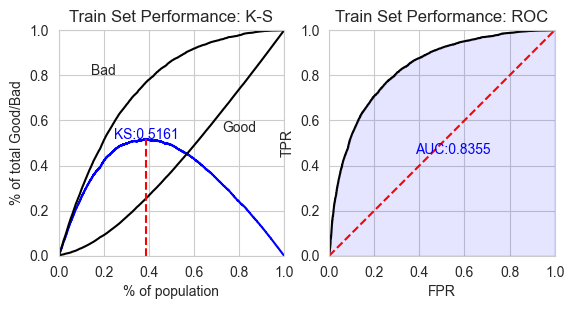

In [ ]:
train_perf = sc.perf_eva(
    y_train,
    train_pred,
    title="Train Set Performance",
)

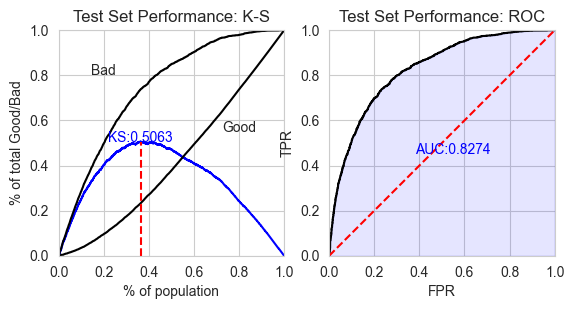

In [67]:
test_perf = sc.perf_eva(
    y_test,
    test_pred,
    title="Test Set Performance",
)

In [84]:
card = sc.scorecard(
    bins,
    lr,
    X_train.columns,
)

Scorecard

In [ ]:
card_df = pd.concat(card)

card_df.index.names = ["card_section", "original_index"]
card_df

variable  \
card_section              original_index                              
basepoints                0                              basepoints   
scoring_FICO              0                            scoring_FICO   
                          1                            scoring_FICO   
                          2                            scoring_FICO   
                          3                            scoring_FICO   
oproc_refin               32                            oproc_refin   
                          33                            oproc_refin   
                          34                            oproc_refin   
is_r                      35                                   is_r   
                          36                                   is_r   
rata_annuita              4                            rata_annuita   
                          5                            rata_annuita   
                          6                            rata_annuita   
                          7                            rata_annuita   
                          8                            rata_annuita   
kod_partnera              37                           kod_partnera   
                          38                           kod_partnera   
                          39                           kod_partnera   
grupa_ryzyka              40                           grupa_ryzyka   
                          41                           grupa_ryzyka   
                          42                           grupa_ryzyka   
delta_oproc_refinansowana 9               delta_oproc_refinansowana   
                          10              delta_oproc_refinansowana   
                          11              delta_oproc_refinansowana   
                          12              delta_oproc_refinansowana   
                          13              delta_oproc_refinansowana   
delta_oproc_konkurencji   43                delta_oproc_konkurencji   
                          44                delta_oproc_konkurencji   
                          45                delta_oproc_konkurencji   
is_n                      14                                   is_n   
                          15                                   is_n   
kwota_kredytu             16                          kwota_kredytu   
                          17                          kwota_kredytu   
                          18                          kwota_kredytu   
                          19                          kwota_kredytu   
                          20                          kwota_kredytu   
koszt_pieniadza           21                        koszt_pieniadza   
                          22                        koszt_pieniadza   
                          23                        koszt_pieniadza   
                          24                        koszt_pieniadza   
                          25                        koszt_pieniadza   
                          26                        koszt_pieniadza   
                          27                        koszt_pieniadza   
okres_kredytu             46                          okres_kredytu   
                          47                          okres_kredytu   
                          48                          okres_kredytu   
                          49                          okres_kredytu   
oproc_propon              50                           oproc_propon   
                          51                           oproc_propon   
                          52                           oproc_propon   
                          53                           oproc_propon   
typ_umowy                 54                              typ_umowy   
                          55                              typ_umowy   
                          56                              typ_umowy   
oproc_konkur              28                           oproc_konkur   
            

In [74]:
train_score = sc.scorecard_ply(
    train,
    card,
)

train_score

,score
0,635.0
1,629.0
2,468.0
3,369.0
4,421.0
...,...
39993,633.0
39994,481.0
39995,511.0
39997,498.0


In [80]:
test_score = sc.scorecard_ply(
    test,
    card,
)

test_score

,score
6,295.0
12,475.0
14,527.0
16,563.0
20,572.0
...,...
39974,518.0
39983,365.0
39988,428.0
39996,651.0


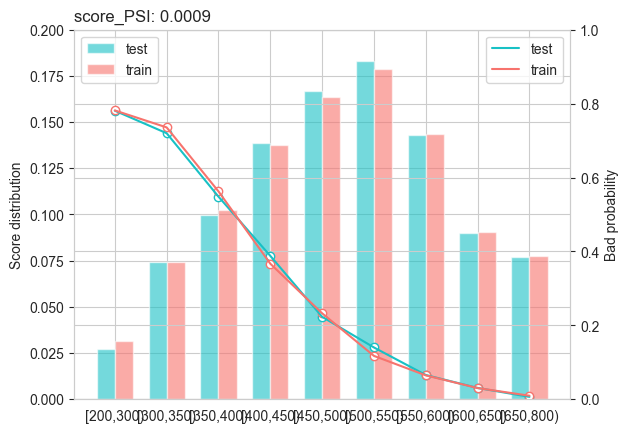

{'psi':   variable       PSI
 0    score  0.000906,
 'pic': {'score': <Figure size 640x480 with 2 Axes>}}

In [82]:
sc.perf_psi(
    score={
        "train": train_score,
        "test": test_score,
    },
    label={
        "train": y_train,
        "test": y_test,
    },
)